# Q1

In [15]:
import numpy as np
import pymc as pm
import arviz as az
import scipy.stats as stats


np.random.seed(42)
x = stats.gamma(a=2).rvs(1000)  # Gamma-distributed data
y = 0.5 * x + stats.t(df=3).rvs(1000)  # Introduce dependency with t-distributed noise


u_x = stats.gamma(a=2).cdf(x)
u_y = stats.t(df=3).cdf(y)


z_x = stats.norm.ppf(u_x)
z_y = stats.norm.ppf(u_y)


with pm.Model() as copula_model:
    # Define the Cholesky factor of the correlation matrix
    packed_chol, _ = pm.LKJCholeskyCov(
        'packed_chol', n=2, eta=2, sd_dist=pm.HalfNormal.dist(1), compute_corr=True
    )

    # Expand to get the full lower-triangular matrix
    chol = pm.expand_packed_triangular(2, packed_chol)

    # Ensure observed data is in the correct format
    observed_data = np.column_stack([z_x, z_y]).astype(np.float64)

    # Define the Gaussian Copula
    copula = pm.MvNormal('copula', mu=np.zeros(2), chol=chol, observed=observed_data)

    # Perform inference
    trace = pm.sample(1000, return_inferencedata=True)
# Step 4: Analyze results
az.plot_trace(trace)
az.summary(trace)


ValueError: too many values to unpack (expected 2)

A copula is a statistical function that captures dependencies between random variables, allowing us to model joint distributions by separating marginal distributions from dependencies.

we can use copulas to generate correlated predictors for regression models and extend Generalized Linear Models to non-normal multivariate responses.

# Q2

In [16]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Data dimensions
n = 200  # Number of observations
p = 10   # Number of predictors (some will be irrelevant)

# True coefficients (only first 3 matter)
true_beta = np.array([2.5, -1.8, 3.7] + [0] * (p - 3))

# Design matrix (normally distributed predictors)
X = np.random.randn(n, p)

# Generate response variable with noise
y = X @ true_beta + np.random.randn(n) * 0.5  # Add noise

# Standardize data
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()


In [17]:
with pm.Model() as spike_slab_model:
    # Spike-and-Slab Priors
    gamma = pm.Bernoulli("gamma", p=0.5, shape=p)  # Variable selection
    
    slab_sigma = pm.HalfNormal("slab_sigma", 1.0)
    spike_sigma = pm.HalfNormal("spike_sigma", 0.1)
    
    beta = pm.Normal("beta", mu=0, sigma=gamma * slab_sigma + (1 - gamma) * spike_sigma, shape=p)
    
    sigma = pm.HalfNormal("sigma", 1.0)
    
    # Likelihood
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # Inference
    trace_spike_slab = pm.sample(2000, return_inferencedata=True, target_accept=0.9)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gamma]
>NUTS: [slab_sigma, spike_sigma, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
with pm.Model() as normal_prior_model:
    # Normal priors (weakly regularizing)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=p)  # Diffuse normal priors
    sigma = pm.HalfNormal("sigma", 1.0)
    
    # Likelihood
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # Inference
    trace_normal = pm.sample(2000, return_inferencedata=True, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


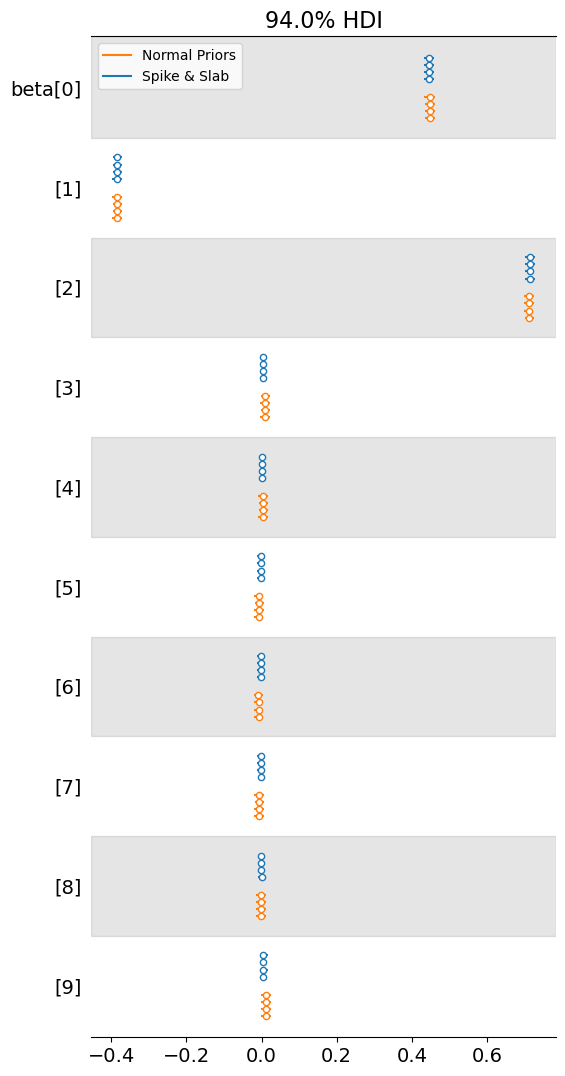

In [19]:
import arviz as az

# Compare posterior distributions of beta coefficients
az.plot_forest([trace_spike_slab, trace_normal], model_names=["Spike & Slab", "Normal Priors"], var_names=["beta"])
plt.show()


# Q3

In [20]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# Set random seed
np.random.seed(42)

# Data dimensions
n = 200  # Observations
p = 10   # Features (some irrelevant)
m = 2    # Multivariate response dimensions

# True regression coefficients (only first 3 features are relevant)
true_beta = np.array([[2.5, -1.8], [3.7, 2.2], [-1.2, 0.8]] + [[0, 0]] * (p - 3))

# Covariates (design matrix)
X = np.random.randn(n, p)

# Response variable (multivariate normal)
y = X @ true_beta + np.random.randn(n, m) * 0.5  # Add noise

# Standardize features and response
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)


In [23]:
with pm.Model() as horseshoe_model:
    # Global shrinkage parameter (τ)
    tau = pm.HalfCauchy("tau", beta=1)

    # Local shrinkage parameters (λ_j)
    lambda_j = pm.HalfCauchy("lambda_j", beta=1, shape=p)

    # Horseshoe prior for regression coefficients
    beta = pm.Normal("beta", mu=0, sigma=lambda_j * tau, shape=(p, m))

    # Likelihood
    sigma = pm.HalfNormal("sigma", 1.0, shape=m)  # Independent noise per output
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Inference
    trace_horseshoe = pm.sample(2000, return_inferencedata=True, target_accept=0.9)


ValueError: Incompatible Elemwise input shapes [(10, 2), (1, 10)]

In [24]:
with pm.Model() as spike_slab_model:
    # Variable selection indicator γ
    gamma = pm.Bernoulli("gamma", p=0.5, shape=p)  
    
    # Slab and Spike variances
    slab_sigma = pm.HalfNormal("slab_sigma", 1.0)
    spike_sigma = pm.HalfNormal("spike_sigma", 0.1)

    # Coefficients with spike-and-slab prior
    beta = pm.Normal("beta", mu=0, sigma=gamma * slab_sigma + (1 - gamma) * spike_sigma, shape=(p, m))

    # Likelihood
    sigma = pm.HalfNormal("sigma", 1.0, shape=m)  # Independent noise per output
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Inference
    trace_spike_slab = pm.sample(2000, return_inferencedata=True, target_accept=0.9)


ValueError: Incompatible Elemwise input shapes [(10, 2), (1, 10)]